In [ ]:
import warnings
warnings.filterwarnings("ignore")

import tensorflow as tf
import os
import numpy as np
import random
from tqdm.auto import tqdm
from skimage.io import imread, imshow
from skimage.transform import resize
import matplotlib.pyplot as plt
from glob import glob
import cv2
from skimage.io import imread, imshow, show

from tensorflow import keras
from keras import layers
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input

seed = 42
np.random.seed = seed  # To get same random seed everytime we run the whole thing.
tf.random.set_seed(42)
random.seed(seed)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install -U tensorflow-addons
import tensorflow_addons as tfa

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 612.1/612.1 kB 11.2 MB/s eta 0:00:00


## Dataset Import


In [ ]:
print(len(os.listdir("/content/drive/MyDrive/ICCIT 2023/Selected_data/H1")))
print(len(os.listdir("/content/drive/MyDrive/ICCIT 2023/Selected_data/H2")))
print(len(os.listdir("/content/drive/MyDrive/ICCIT 2023/Selected_data/H3")))
print(len(os.listdir("/content/drive/MyDrive/ICCIT 2023/Selected_data/H5")))
print(len(os.listdir("/content/drive/MyDrive/ICCIT 2023/Selected_data/H6")))

700
700
700
700
700


In [ ]:
!pip install --root-user-action=ignore split-folders

In [ ]:
# Only one time run cell
import splitfolders

input_folder = "/content/drive/MyDrive/ICCIT 2023/Selected_data"
output = "/content/split_data/"

splitfolders.ratio(input_folder, output=output, seed=42, ratio=(0.90, 0.10))

Copying files: 3500 files [00:46, 74.69 files/s] 


## Vit Model Creation

In [ ]:
input_size = 256
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 32
num_epochs = 100
image_size = 72  # We'll resize input images to this size
patch_size = 6  # Size of the patches to be extract from the input images
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 4
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers
transformer_layers = 4
mlp_head_units = [2048, 1024]  # Size of the dense layers of the final classifier

In [ ]:
data_augmentation = keras.Sequential(
    [
        layers.Normalization(),
        layers.Resizing(image_size, image_size),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(factor=0.02),
        layers.RandomZoom(height_factor=0.2, width_factor=0.2),
    ],
    name="data_augmentation",
)

# Compute the mean and the variance of the training data for normalization.
# data_augmentation.layers[0].adapt(x_train)

def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

class Patches(layers.Layer):
    def __init__(self, patch_size):
        super().__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super().__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

In [2]:
def create_vit_part(input):

    # input_shape = (input_size, input_size, 3)
    # num_classes = 5

    # inputs = layers.Input(shape=input_shape)
    # Augment data.

    data_augmentation = keras.Sequential(
    [
        layers.Normalization(),
        layers.Resizing(image_size, image_size),
        # layers.RandomFlip("horizontal"),
        layers.RandomRotation(factor=0.02),
        layers.RandomZoom(height_factor=0.2, width_factor=0.2),
    ],
    name="data_augmentation")

    augmented = data_augmentation(input)
    # Create patches.
    patches = Patches(patch_size)(augmented)
    # Encode patches.
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)  #9216
    # Add MLP.
    # features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    # Classify outputs.
    # logits = layers.Dense(num_classes)(features)
    # Create the Keras model.
    # model = keras.Model(inputs=inputs, outputs=logits)

    x = layers.Dense(2048, activation=tf.nn.gelu)(representation)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(1024, activation=tf.nn.relu)(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(512, activation=tf.nn.relu)(x)
    # x = layers.Dropout(0.5)(x)

    return x  #512

# vit_model = create_vit_classifier(data_augmentation)
# vit_model.summary()


## Transfer Learning Model

In [1]:


def transfer_model(input):

    base_model = tf.keras.applications.vgg16.VGG16(
                                                include_top=False,
                                                weights='imagenet',
                                                input_shape=(input_size, input_size, 3),
                                                pooling=None)

    base_model.trainable = False

    x = base_model(input, training=False)

    x = layers.GlobalAveragePooling2D()(x)
    # x = layers.Dropout(0.2)(x)
    # x = tf.keras.layers.Dense(1024,activation='relu')(x)
    # x = tf.keras.layers.Dropout(0.6)(x)
    # x = tf.keras.layers.Dense(512,activation='relu')(x)
    # x = tf.keras.layers.Dropout(0.5)(x)
    # output = tf.keras.layers.Dense(5, activation="softmax")(x)

    # model = keras.Model(inputs = input, outputs = output)

    return x #512

# model = transfer_model()
# print(model.summary())

## Casceding Model Creation

In [ ]:
def Cascade_model():

    input = keras.Input(shape=(input_size, input_size, 3))  # (None, 256, 256, 3)
    num_classes = 5

    vit_output = create_vit_part(input)       #(None, 2048)
    tranfer_output = transfer_model(input)    #(None, 2048)

    multiplied = layers.Multiply()([vit_output, tranfer_output])
    x = layers.Dropout(0.5)(multiplied)

    x = tf.keras.layers.Dense(256,activation='relu')(x)
    x = tf.keras.layers.Dropout(0.5)(x)

    output = tf.keras.layers.Dense(num_classes, activation="softmax")(x)

    model = keras.Model(inputs = input, outputs = output)

    return model


In [ ]:
demo_model = Cascade_model()
demo_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_7 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 data_augmentation (Sequent  (None, 72, 72, 3)            7         ['input_7[0][0]']             
 ial)                                                                                             
                                                                                                  
 patches_1 (Patches)         (None, None, 108)            0         ['data_augmentation[0][0]']   
                                                                                                  
 patch_encoder_1 (PatchEnco  (None, 144, 64)              16192     ['patches_1[0][0]']     

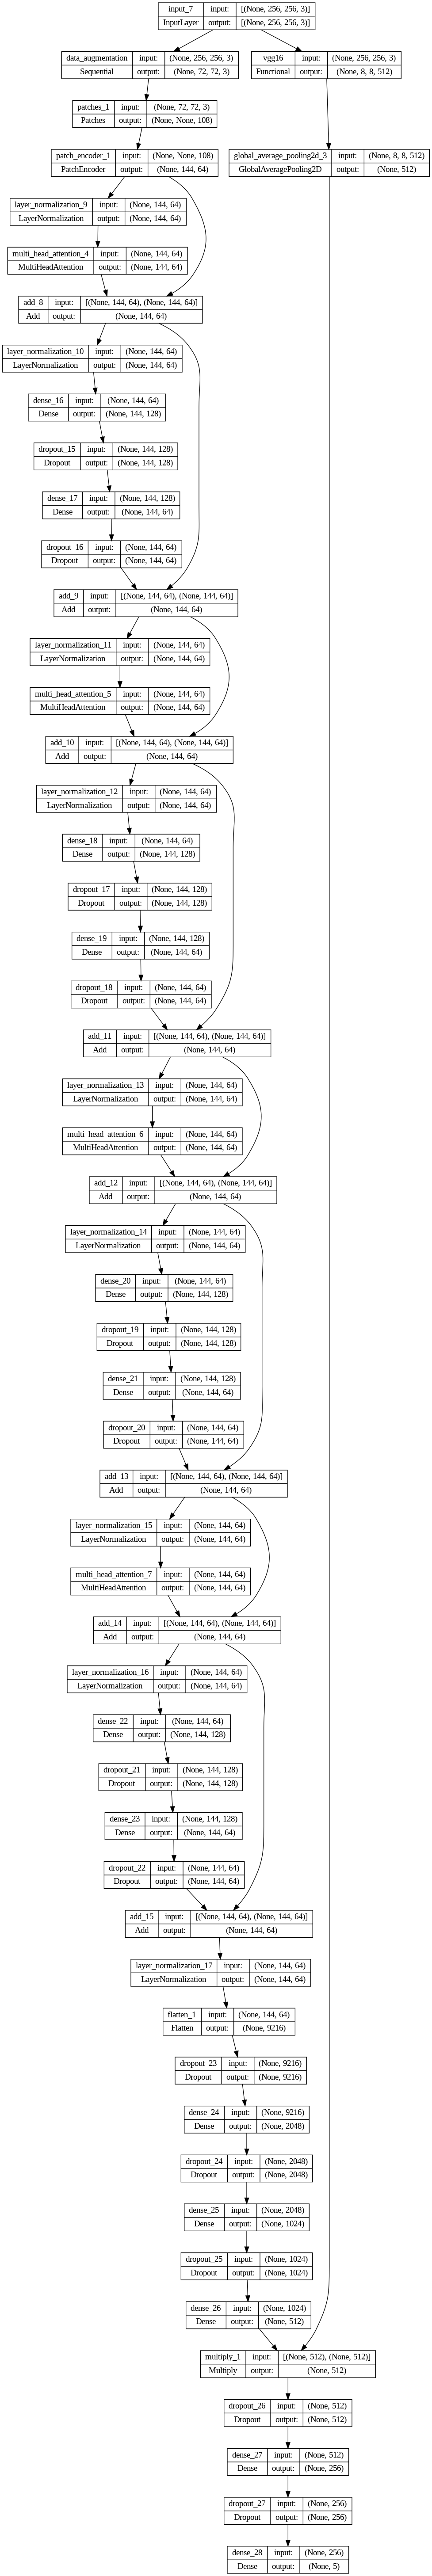

In [ ]:
tf.keras.utils.plot_model(demo_model, show_shapes=True)

## Training

In [ ]:
# from sklearn.model_selection import StratifiedKFold
# cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

fold_no = 1
acc_per_fold = []
history_all = []

for k in range(5):

    print('   ')
    print(f'Training for fold {fold_no} ...', '\n')
    tf.random.set_seed(43+k)

    data_generator_with_aug = ImageDataGenerator(preprocessing_function=preprocess_input,
                                   horizontal_flip=True,
                                   vertical_flip=True)

    data_generator_no_aug = ImageDataGenerator(preprocessing_function=preprocess_input)

    train_generator = data_generator_with_aug.flow_from_directory(
                        '/content/split_data/train',
                        target_size=(256, 256),
                        batch_size=batch_size,
                        class_mode='categorical',
                        shuffle=True)

    validation_generator = data_generator_no_aug.flow_from_directory(
                        '/content/split_data/val',
                        target_size=(256, 256),
                        batch_size=batch_size,
                        class_mode='categorical',
                        shuffle=True)



    model = Cascade_model()

    optimizer = tfa.optimizers.AdamW(learning_rate=learning_rate,
                                     weight_decay=weight_decay)

    model.compile(optimizer=optimizer,
                  loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
                  metrics=[tf.keras.metrics.CategoricalAccuracy(name="accuracy")])

    history = model.fit(
        train_generator,
        epochs=num_epochs,
        validation_data = validation_generator,
        verbose = 1)

    result = model.evaluate(validation_generator)
    print(f"Test accuracy: {round(result[1] * 100, 2)}%", '\n')

    acc_per_fold.append(result[1]*100)
    history_all.append(history)

    fold_no = fold_no + 1


   
Training for fold 1 ... 

Found 3150 images belonging to 5 classes.
Found 350 images belonging to 5 classes.
Epoch 1/100
99/99 [==============================] - 27s 116ms/step - loss: 3.5691 - accuracy: 0.3692 - val_loss: 1.2170 - val_accuracy: 0.5286
Epoch 2/100
99/99 [==============================] - 9s 93ms/step - loss: 1.6191 - accuracy: 0.4489 - val_loss: 1.2261 - val_accuracy: 0.5514
Epoch 3/100
99/99 [==============================] - 9s 90ms/step - loss: 1.3664 - accuracy: 0.4867 - val_loss: 1.1598 - val_accuracy: 0.5429
Epoch 4/100
99/99 [==============================] - 9s 89ms/step - loss: 1.2339 - accuracy: 0.5317 - val_loss: 1.0677 - val_accuracy: 0.5943
Epoch 5/100
99/99 [==============================] - 9s 93ms/step - loss: 1.2290 - accuracy: 0.5248 - val_loss: 1.0858 - val_accuracy: 0.6171
Epoch 6/100
99/99 [==============================] - 9s 93ms/step - loss: 1.1566 - accuracy: 0.5575 - val_loss: 1.0308 - val_accuracy: 0.6057
Epoch 7/100
99/99 [==============

KeyboardInterrupt: ignored

In [ ]:
print(acc_per_fold, '\n')

mean = np.mean(np.array(acc_per_fold))
std = np.std(np.array(acc_per_fold))

print(f"Overall Accuracy is : {mean}+-{std}")

In [ ]:
history_nparray = np.zeros((20, 100))
print(len(history_all[0].history))

count = 0

for k in tqdm(range(5)):

    aa = history_all[k].history      # Dictionary

    history_nparray[count, :] = np.array(aa['loss'])
    count = count+1
    history_nparray[count, :] = np.array(aa['accuracy'])
    count = count+1
    history_nparray[count, :] = np.array(aa['val_loss'])
    count = count+1
    history_nparray[count, :] = np.array(aa['val_accuracy'])
    count = count+1

print(count)
print(history_nparray[-1,:])

In [ ]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(range(100), history_nparray[13,:], label='Training Accuracy')
plt.plot(range(100), history_nparray[15,:], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(100), history_nparray[12,:], label='Training Loss')
plt.plot(range(100), history_nparray[14,:], label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
# np.save('/content/Combined_02.npy', history_nparray)
# model.save('/content/Combined_idea_02.h5')